In [1]:
pip install boruta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.3 MB/s eta 0:00:00


In [2]:
pip install sklearn-genetic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.0 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import joblib
import datetime
import matplotlib.pyplot as plt
import shap
import warnings
import os
from collections import Counter
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import f_classif, f_regression, mutual_info_classif, mutual_info_regression, SelectKBest, RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
from sklearn.utils import check_X_y
from scipy import sparse
warnings.filterwarnings('ignore')

SAVE_LEARNING_CURVE = True  # Toggle to True if you want to plot learning curves
SAVE_SHAP_PNG = True

In [6]:
# === Feature Logging ===
def log_feature_importance(features, scores, method):
    df = pd.DataFrame({"Feature": features, "Importance": scores})
    filename = f"feature_importance_{method}.csv"
    df.to_csv(filename, index=False)
    print(f"📄 Feature importances saved to {filename}")


In [7]:
# === Evaluate model performance ===
def evaluate_model(task_type, model, X_test, y_test):
    y_pred = model.predict(X_test)
    if task_type == 'r':
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, r2
    else:
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        return {'Accuracy': acc, 'Report': report}, acc


In [16]:
def detect_task_type(y):
    import pandas as pd
    y = pd.Series(y)

    if y.dtype == "object" or y.dtype.name == "category":
        return 'c'

    if pd.api.types.is_integer_dtype(y) and y.nunique() < 20:
        return 'c'

    if pd.api.types.is_numeric_dtype(y):
        uniq = y.nunique()
        if pd.api.types.is_float_dtype(y) or uniq > 20:
            return 'r'
        else:
            return 'c'

    # If unable to determine, ask user
    task = input("Unable to determine task type automatically. Enter 'c' for classification or 'r' for regression: ").strip().lower()
    while task not in ['c', 'r']:
        task = input("Invalid input. Please enter 'c' for classification or 'r' for regression: ").strip().lower()
    return task


In [8]:
# === Plot learning curve ===
def plot_learning_curve(estimator, X, y, task_type, title="Learning Curve", filename=None):
    if not SAVE_LEARNING_CURVE:
        return
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2' if task_type == 'r' else 'accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()

In [9]:
# === Encode categoricals ===
def encode_categoricals(df):
    df_encoded = df.copy()
    encoder = OrdinalEncoder()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if not cat_cols.empty:
        df_encoded[cat_cols] = encoder.fit_transform(df_encoded[cat_cols].astype(str))
    return df_encoded

In [10]:
# === Feature Selection ===
def apply_feature_selection(method, X, y, task_type, mi_threshold=0.01, p_threshold=0.05):
    if method == 'f_test':
        score_func = f_regression if task_type == 'r' else f_classif
        selector = SelectKBest(score_func=score_func, k='all')
        selector.fit(X, y)
        pvalues = selector.pvalues_
        selected_cols = X.columns[np.where(pvalues < p_threshold)[0]].tolist()
        log_feature_importance(X.columns, pvalues, method)

    elif method == 'mutual_info':
        score_func = mutual_info_regression if task_type == 'r' else mutual_info_classif
        selector = SelectKBest(score_func=score_func, k='all')
        selector.fit(X, y)
        scores = selector.scores_
        selected_cols = X.columns[np.where(scores > mi_threshold)[0]].tolist()
        log_feature_importance(X.columns, scores, method)

    elif method == 'boruta':
        model = RandomForestRegressor(n_jobs=-1, random_state=42) if task_type == 'r' else RandomForestClassifier(n_jobs=-1, random_state=42)
        X_array, y_array = check_X_y(X, y)
        X_array = pd.DataFrame(X_array, columns=X.columns)
        boruta_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=42)
        boruta_selector.fit(X_array.values, y_array)
        selected_cols = X.columns[boruta_selector.support_].tolist()

    elif method == 'rfe':
        estimator = LinearRegression() if task_type == 'r' else LogisticRegression(solver='liblinear')
        selector = RFE(estimator, n_features_to_select=int(X.shape[1] * 0.5))
        selector.fit(X, y)
        selected_cols = X.columns[selector.support_].tolist()
        log_feature_importance(X.columns, selector.ranking_, method)

    else:
        raise ValueError("Unsupported feature selection method")

    print(f"✅ Selected Features by {method}: {selected_cols}")
    return X[selected_cols]

In [11]:
# === PSI Calculation ===
def calculate_psi(expected, actual, buckets=10):
    expected = np.array(expected)
    actual = np.array(actual)
    if np.std(expected) == 0 or np.std(actual) == 0:
        return 0
    breakpoints = np.linspace(0, 1, buckets + 1)
    scale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-9)
    expected_scaled = scale(expected)
    actual_scaled = scale(actual)
    expected_bins = np.histogram(expected_scaled, bins=breakpoints)[0] / len(expected)
    actual_bins = np.histogram(actual_scaled, bins=breakpoints)[0] / len(actual)
    psi_values = []
    for e, a in zip(expected_bins, actual_bins):
        if e == 0: e = 1e-4
        if a == 0: a = 1e-4
        psi_values.append((e - a) * np.log(e / a))
    return np.sum(psi_values)

In [12]:
# === SHAP Explanation ===
def explain_model_with_shap(model, X_sample):
    explainer = shap.TreeExplainer(model)
    explainer.check_additivity = False
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample)


In [13]:
# === Conditional SMOTE ===
def apply_smote_if_needed(X_train, y_train, task_type):
    if task_type != 'c':
        print("ℹ️ SMOTE not applied: Task is regression.")
        return X_train, y_train

    class_counts = Counter(y_train)
    total = sum(class_counts.values())
    imbalance = any((count / total) < 0.2 for count in class_counts.values())

    if imbalance:
        print(f"⚠️ Imbalanced classes detected: {class_counts}")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        print(f"✅ SMOTE applied: {Counter(y_res)}")
        return X_res, y_res
    else:
        print("✅ No significant class imbalance detected. Skipping SMOTE.")
        return X_train, y_train

📘 Self-Healing AI Framework with Conditional Healing
Enter CSV file path or name: /content/PCOS_data_without_infertility1 (1).csv
✅ Dataset loaded successfully.

🧾 Dataset Columns: ['Sl. No', 'Patient File No.', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'PCOS (Y/N)']
Enter Target Column: PCOS (Y/N)
🎯 Tas

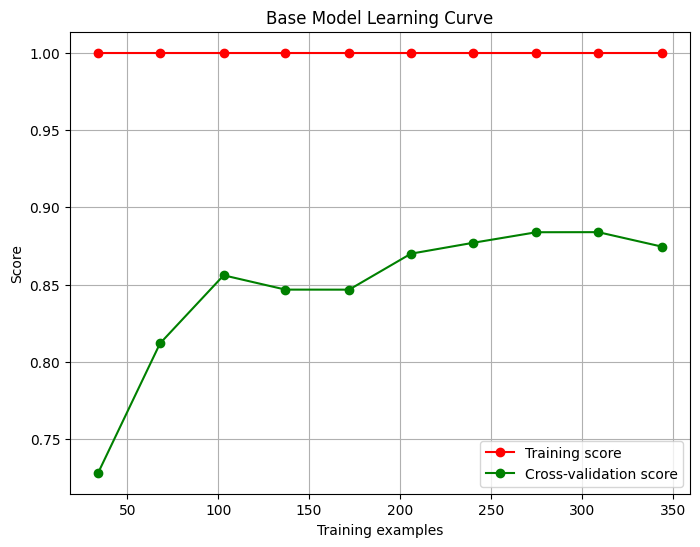


🔍 SHAP Feature Importance for Base Model


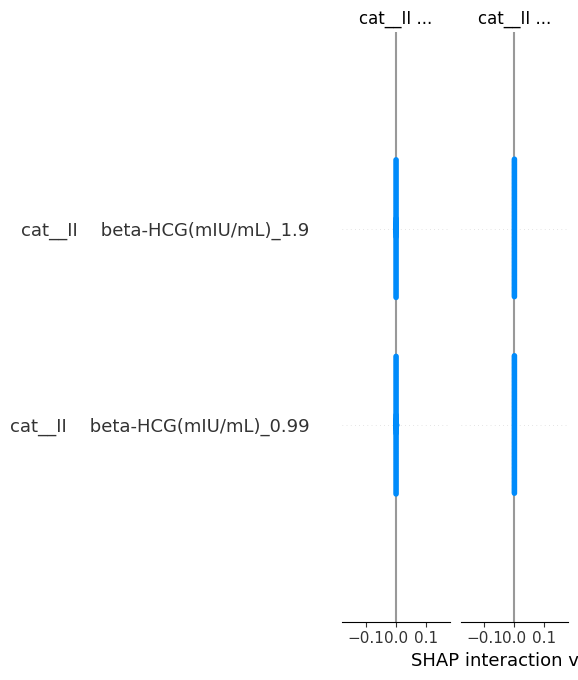


📈 Drift Detection (PSI Scores):
⚠️ Drift detected in column 'Weight (Kg)' | PSI = 0.4059
⚠️ Drift detected in column 'Height(Cm) ' | PSI = 1.0337
⚠️ Drift detected in column 'Blood Group' | PSI = 0.3510
⚠️ Drift detected in column 'RR (breaths/min)' | PSI = 10.9948
⚠️ Drift detected in column 'Hb(g/dl)' | PSI = 1.2676
⚠️ Drift detected in column 'Cycle(R/I)' | PSI = 3.5175
⚠️ Drift detected in column 'Cycle length(days)' | PSI = 3.6250
⚠️ Drift detected in column 'No. of aborptions' | PSI = 2.5185
⚠️ Drift detected in column 'FSH(mIU/mL)' | PSI = 8.7145
⚠️ Drift detected in column 'LH(mIU/mL)' | PSI = 5.3035
⚠️ Drift detected in column 'Hip(inch)' | PSI = 0.2295
⚠️ Drift detected in column 'Waist(inch)' | PSI = 0.9248
⚠️ Drift detected in column 'Waist:Hip Ratio' | PSI = 0.2646
⚠️ Drift detected in column 'TSH (mIU/L)' | PSI = 0.8772
⚠️ Drift detected in column 'PRL(ng/mL)' | PSI = 0.3129
⚠️ Drift detected in column 'Vit D3 (ng/mL)' | PSI = 11.7575
⚠️ Drift detected in column 'RBS(mg/

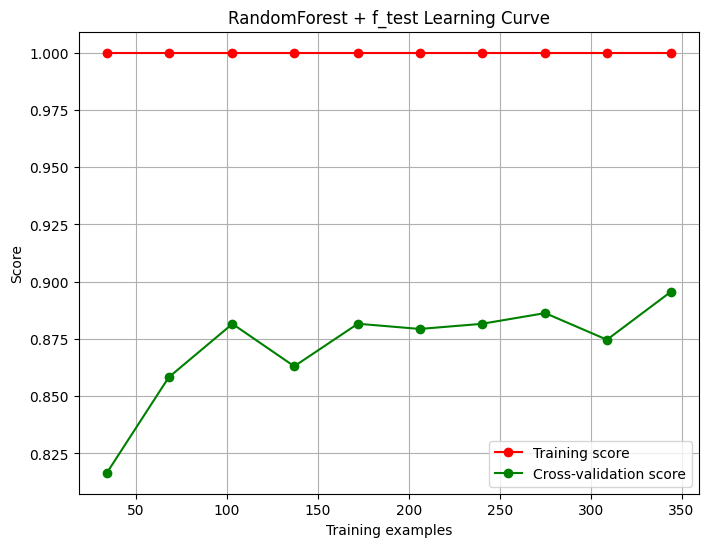

Training DecisionTree with f_test...
Performance: {'Accuracy': 0.8055555555555556, 'Report': {'0': {'precision': 0.8823529411764706, 'recall': 0.821917808219178, 'f1-score': 0.851063829787234, 'support': 73.0}, '1': {'precision': 0.675, 'recall': 0.7714285714285715, 'f1-score': 0.72, 'support': 35.0}, 'accuracy': 0.8055555555555556, 'macro avg': {'precision': 0.7786764705882353, 'recall': 0.7966731898238748, 'f1-score': 0.7855319148936171, 'support': 108.0}, 'weighted avg': {'precision': 0.8151552287581699, 'recall': 0.8055555555555556, 'f1-score': 0.8085894405043341, 'support': 108.0}}}


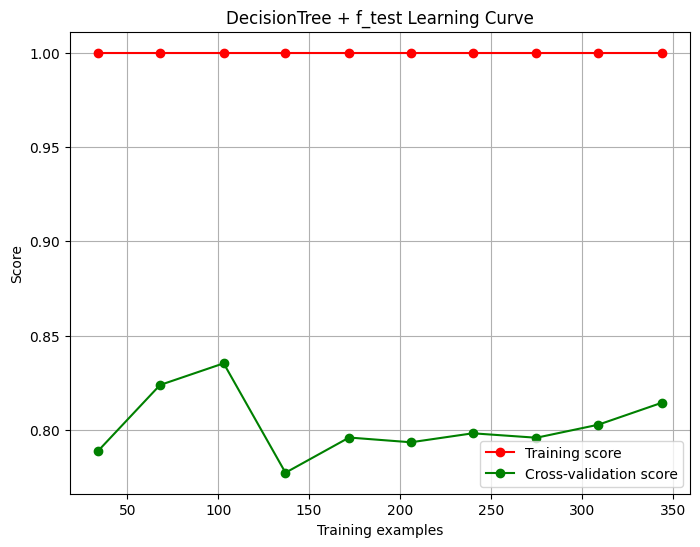

Training SVM with f_test...
Performance: {'Accuracy': 0.8518518518518519, 'Report': {'0': {'precision': 0.9014084507042254, 'recall': 0.8767123287671232, 'f1-score': 0.8888888888888888, 'support': 73.0}, '1': {'precision': 0.7567567567567568, 'recall': 0.8, 'f1-score': 0.7777777777777778, 'support': 35.0}, 'accuracy': 0.8518518518518519, 'macro avg': {'precision': 0.829082603730491, 'recall': 0.8383561643835616, 'f1-score': 0.8333333333333333, 'support': 108.0}, 'weighted avg': {'precision': 0.8545305869249531, 'recall': 0.8518518518518519, 'f1-score': 0.852880658436214, 'support': 108.0}}}


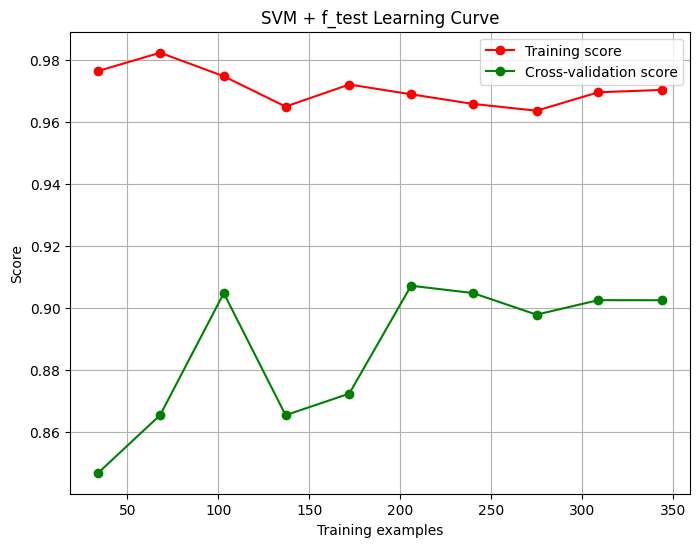

Training KNN with f_test...
Performance: {'Accuracy': 0.8703703703703703, 'Report': {'0': {'precision': 0.8933333333333333, 'recall': 0.9178082191780822, 'f1-score': 0.9054054054054054, 'support': 73.0}, '1': {'precision': 0.8181818181818182, 'recall': 0.7714285714285715, 'f1-score': 0.7941176470588235, 'support': 35.0}, 'accuracy': 0.8703703703703703, 'macro avg': {'precision': 0.8557575757575757, 'recall': 0.8446183953033268, 'f1-score': 0.8497615262321144, 'support': 108.0}, 'weighted avg': {'precision': 0.8689786756453424, 'recall': 0.8703703703703703, 'f1-score': 0.8693399281634576, 'support': 108.0}}}


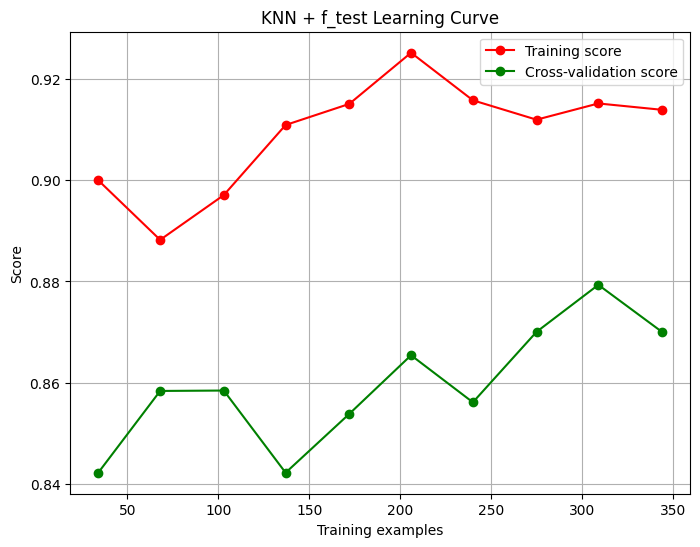


🔍 Feature Selection: mutual_info
📄 Feature importances saved to feature_importance_mutual_info.csv
✅ Selected Features by mutual_info: ['Sl. No', 'Patient File No.', ' Age (yrs)', 'Weight (Kg)', 'BMI', 'Blood Group', 'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'No. of aborptions', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Waist(inch)', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)']
✅ No significant class imbalance detected. Skipping SMOTE.
Training RandomForest with mutual_info...
Performance: {'Accuracy': 0.8888888888888888, 'Report': {'0': {'precision': 0.8860759493670886, 'recall': 0.958904109589041, 'f1-score': 0.9210526315789473, 'support': 73.0}, '1': {'precision': 0.896551724137931, 'recall': 0.7428571428571429, 'f1-score': 0.8125, 'support': 35.0}, 'accuracy': 0.88

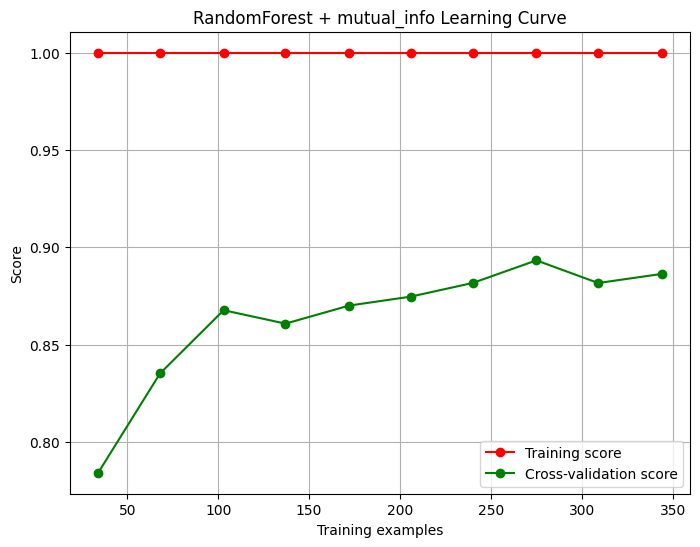

Training DecisionTree with mutual_info...
Performance: {'Accuracy': 0.8055555555555556, 'Report': {'0': {'precision': 0.8939393939393939, 'recall': 0.8082191780821918, 'f1-score': 0.8489208633093526, 'support': 73.0}, '1': {'precision': 0.6666666666666666, 'recall': 0.8, 'f1-score': 0.7272727272727273, 'support': 35.0}, 'accuracy': 0.8055555555555556, 'macro avg': {'precision': 0.7803030303030303, 'recall': 0.8041095890410959, 'f1-score': 0.7880967952910399, 'support': 108.0}, 'weighted avg': {'precision': 0.8202861952861952, 'recall': 0.8055555555555556, 'f1-score': 0.8094978562604462, 'support': 108.0}}}


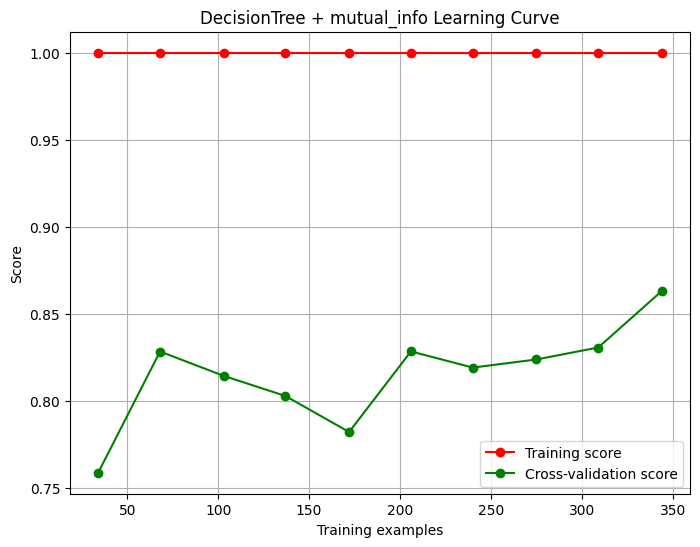

Training SVM with mutual_info...
Performance: {'Accuracy': 0.8888888888888888, 'Report': {'0': {'precision': 0.9295774647887324, 'recall': 0.9041095890410958, 'f1-score': 0.9166666666666666, 'support': 73.0}, '1': {'precision': 0.8108108108108109, 'recall': 0.8571428571428571, 'f1-score': 0.8333333333333334, 'support': 35.0}, 'accuracy': 0.8888888888888888, 'macro avg': {'precision': 0.8701941377997716, 'recall': 0.8806262230919765, 'f1-score': 0.875, 'support': 108.0}, 'weighted avg': {'precision': 0.8910882713699614, 'recall': 0.8888888888888888, 'f1-score': 0.8896604938271605, 'support': 108.0}}}


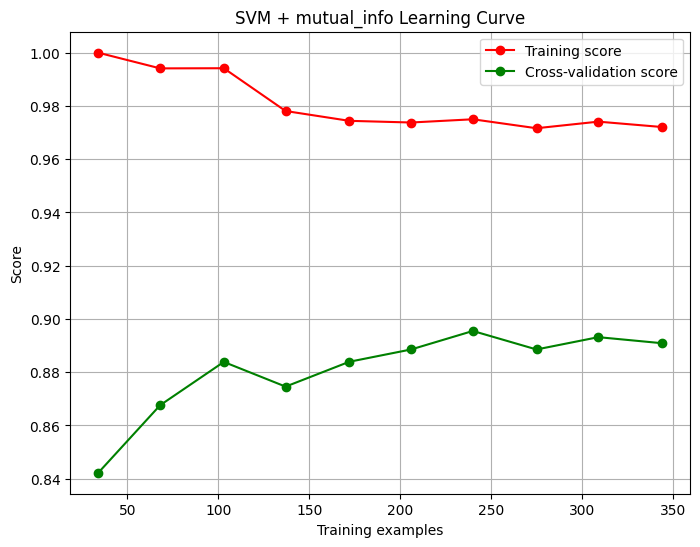

Training KNN with mutual_info...
Performance: {'Accuracy': 0.8796296296296297, 'Report': {'0': {'precision': 0.875, 'recall': 0.958904109589041, 'f1-score': 0.9150326797385621, 'support': 73.0}, '1': {'precision': 0.8928571428571429, 'recall': 0.7142857142857143, 'f1-score': 0.7936507936507936, 'support': 35.0}, 'accuracy': 0.8796296296296297, 'macro avg': {'precision': 0.8839285714285714, 'recall': 0.8365949119373777, 'f1-score': 0.8543417366946778, 'support': 108.0}, 'weighted avg': {'precision': 0.8807870370370371, 'recall': 0.8796296296296297, 'f1-score': 0.8756959573953038, 'support': 108.0}}}


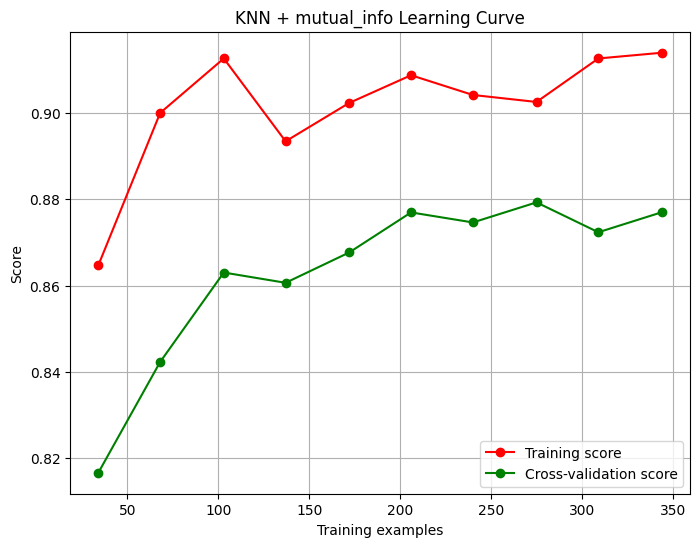


🔍 Feature Selection: boruta
✅ Selected Features by boruta: ['Sl. No', 'Patient File No.', 'Cycle(R/I)', 'Cycle length(days)', 'FSH/LH', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)']
✅ No significant class imbalance detected. Skipping SMOTE.
Training RandomForest with boruta...
Performance: {'Accuracy': 0.9074074074074074, 'Report': {'0': {'precision': 0.9315068493150684, 'recall': 0.9315068493150684, 'f1-score': 0.9315068493150684, 'support': 73.0}, '1': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 35.0}, 'accuracy': 0.9074074074074074, 'macro avg': {'precision': 0.8943248532289627, 'recall': 0.8943248532289627, 'f1-score': 0.8943248532289627, 'support': 108.0}, 'weighted avg': {'precision': 0.9074074074074074, 'recall': 0.9074074074074074, 'f1-score': 0.9074074074074074, 'support': 108.0}}}


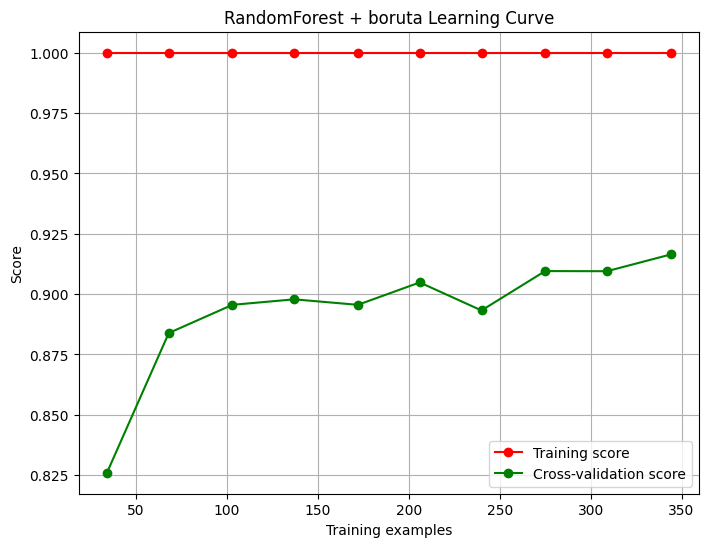

Training DecisionTree with boruta...
Performance: {'Accuracy': 0.8703703703703703, 'Report': {'0': {'precision': 0.9041095890410958, 'recall': 0.9041095890410958, 'f1-score': 0.9041095890410958, 'support': 73.0}, '1': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8, 'support': 35.0}, 'accuracy': 0.8703703703703703, 'macro avg': {'precision': 0.8520547945205479, 'recall': 0.8520547945205479, 'f1-score': 0.8520547945205479, 'support': 108.0}, 'weighted avg': {'precision': 0.8703703703703703, 'recall': 0.8703703703703703, 'f1-score': 0.8703703703703703, 'support': 108.0}}}


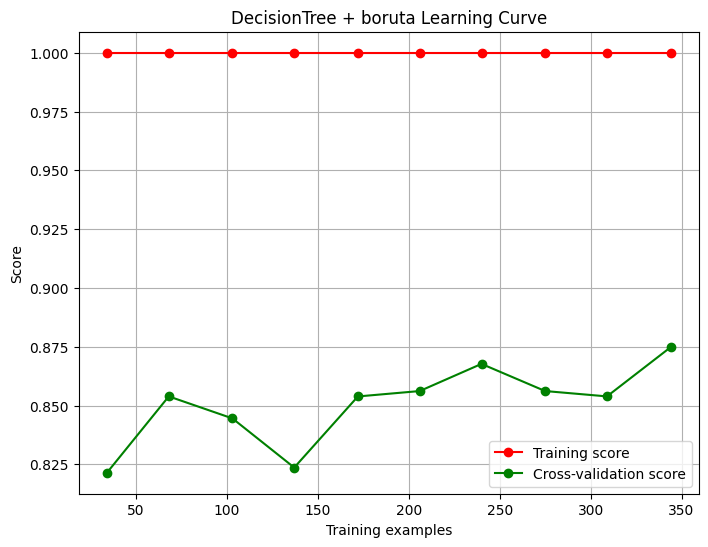

Training SVM with boruta...
Performance: {'Accuracy': 0.8518518518518519, 'Report': {'0': {'precision': 0.9130434782608695, 'recall': 0.863013698630137, 'f1-score': 0.8873239436619719, 'support': 73.0}, '1': {'precision': 0.7435897435897436, 'recall': 0.8285714285714286, 'f1-score': 0.7837837837837838, 'support': 35.0}, 'accuracy': 0.8518518518518519, 'macro avg': {'precision': 0.8283166109253066, 'recall': 0.8457925636007828, 'f1-score': 0.8355538637228779, 'support': 108.0}, 'weighted avg': {'precision': 0.8581279160989305, 'recall': 0.8518518518518519, 'f1-score': 0.8537692622199665, 'support': 108.0}}}


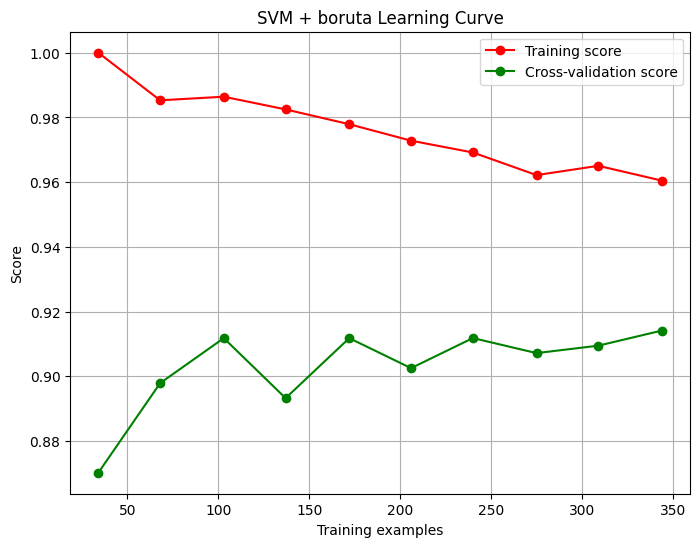

Training KNN with boruta...
Performance: {'Accuracy': 0.8333333333333334, 'Report': {'0': {'precision': 0.8767123287671232, 'recall': 0.8767123287671232, 'f1-score': 0.8767123287671232, 'support': 73.0}, '1': {'precision': 0.7428571428571429, 'recall': 0.7428571428571429, 'f1-score': 0.7428571428571429, 'support': 35.0}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8097847358121331, 'recall': 0.8097847358121331, 'f1-score': 0.8097847358121331, 'support': 108.0}, 'weighted avg': {'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support': 108.0}}}


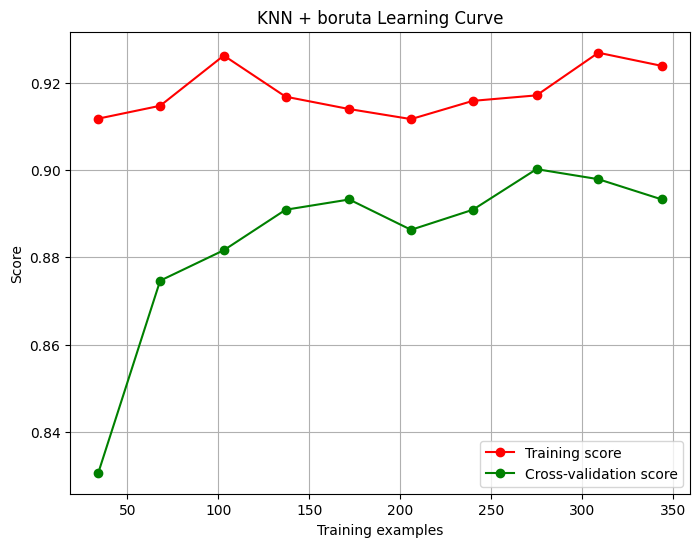


🔍 Feature Selection: rfe
📄 Feature importances saved to feature_importance_rfe.csv
✅ Selected Features by rfe: ['Weight (Kg)', 'Height(Cm) ', 'BMI', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', 'LH(mIU/mL)', 'PRG(ng/mL)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)', 'Follicle No. (R)']
✅ No significant class imbalance detected. Skipping SMOTE.
Training RandomForest with rfe...
Performance: {'Accuracy': 0.8888888888888888, 'Report': {'0': {'precision': 0.9178082191780822, 'recall': 0.9178082191780822, 'f1-score': 0.9178082191780822, 'support': 73.0}, '1': {'precision': 0.8285714285714286, 'recall': 0.8285714285714286, 'f1-score': 0.8285714285714286, 'support': 35.0}, 'accuracy': 0.8888888888888888, 'macro avg': {'precision': 0.8731898238747554, 'recall': 0.8731898238747554, 'f1-score': 0.8731

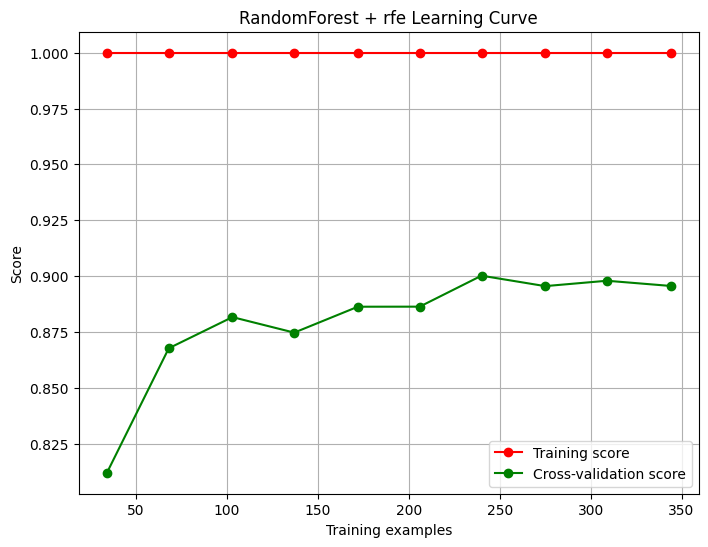

Training DecisionTree with rfe...
Performance: {'Accuracy': 0.8148148148148148, 'Report': {'0': {'precision': 0.8955223880597015, 'recall': 0.821917808219178, 'f1-score': 0.8571428571428571, 'support': 73.0}, '1': {'precision': 0.6829268292682927, 'recall': 0.8, 'f1-score': 0.7368421052631579, 'support': 35.0}, 'accuracy': 0.8148148148148148, 'macro avg': {'precision': 0.7892246086639971, 'recall': 0.810958904109589, 'f1-score': 0.7969924812030075, 'support': 108.0}, 'weighted avg': {'precision': 0.8266256791921153, 'recall': 0.8148148148148148, 'f1-score': 0.8181565023670286, 'support': 108.0}}}


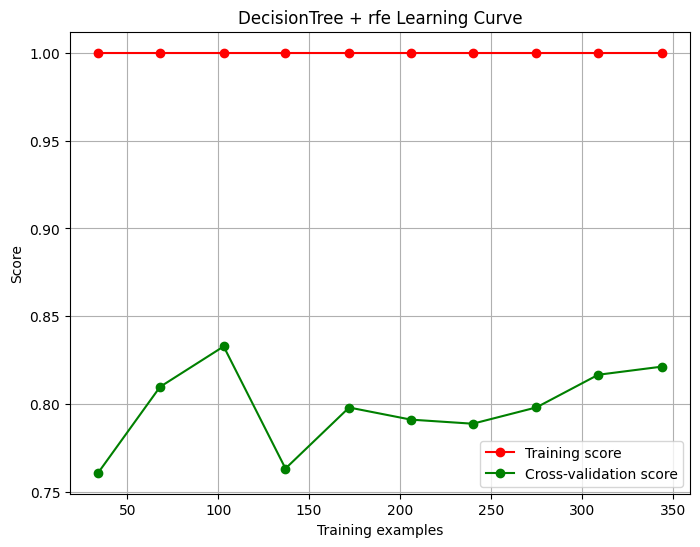

Training SVM with rfe...
Performance: {'Accuracy': 0.8888888888888888, 'Report': {'0': {'precision': 0.9178082191780822, 'recall': 0.9178082191780822, 'f1-score': 0.9178082191780822, 'support': 73.0}, '1': {'precision': 0.8285714285714286, 'recall': 0.8285714285714286, 'f1-score': 0.8285714285714286, 'support': 35.0}, 'accuracy': 0.8888888888888888, 'macro avg': {'precision': 0.8731898238747554, 'recall': 0.8731898238747554, 'f1-score': 0.8731898238747554, 'support': 108.0}, 'weighted avg': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, 'support': 108.0}}}


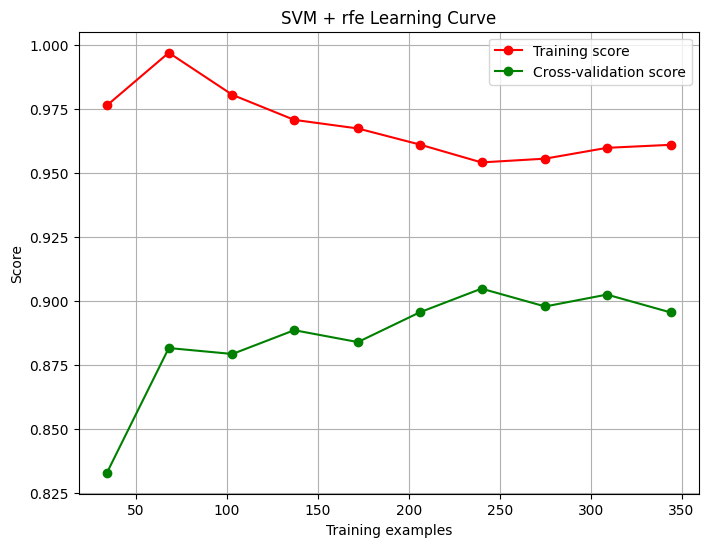

Training KNN with rfe...
Performance: {'Accuracy': 0.8796296296296297, 'Report': {'0': {'precision': 0.9411764705882353, 'recall': 0.8767123287671232, 'f1-score': 0.9078014184397163, 'support': 73.0}, '1': {'precision': 0.775, 'recall': 0.8857142857142857, 'f1-score': 0.8266666666666667, 'support': 35.0}, 'accuracy': 0.8796296296296297, 'macro avg': {'precision': 0.8580882352941177, 'recall': 0.8812133072407045, 'f1-score': 0.8672340425531915, 'support': 108.0}, 'weighted avg': {'precision': 0.8873229847494554, 'recall': 0.8796296296296297, 'f1-score': 0.8815077488836354, 'support': 108.0}}}


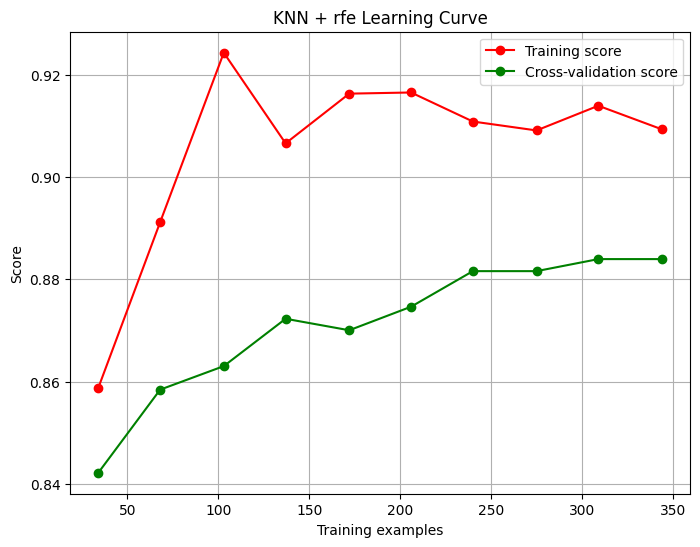


✅ Best Model Saved: best_model_RandomForest_boruta_20250914_180107.pkl | Model: RandomForest | FS: boruta | Score: 0.9074


In [24]:
# === Main Pipeline ===
def self_healing_ai_framework():
    print("\U0001F4D8 Self-Healing AI Framework with Conditional Healing")
    file_path = input("Enter CSV file path or name: ").strip()
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully.")
    print("\n🧾 Dataset Columns:", list(df.columns))

    target_column = input("Enter Target Column: ").strip()
    y = df[target_column]

    task_type = detect_task_type(df[target_column])
    print(f"🎯 Task Type Detected: {task_type}")

    X = df.drop(columns=[target_column])

    print("\n⚠️ Dropping rows with missing values (NaNs)...")
    initial_shape = X.shape
    X = X.dropna(axis=0)
    y = y.loc[X.index]
    print(f"Dropped {initial_shape[0] - X.shape[0]} rows due to missing values.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                        stratify=y if task_type == 'c' else None)

    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])

    preprocessor.fit(X_train)
    X_train_trans = preprocessor.transform(X_train)
    X_test_trans = preprocessor.transform(X_test)

    X_train_arr = X_train_trans.toarray() if hasattr(X_train_trans, "toarray") else X_train_trans
    X_test_arr = X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans

    X_train_arr, y_train = apply_smote_if_needed(X_train_arr, y_train, task_type)

    print("\n🔧 Training Base Model (Random Forest)")
    base_model = RandomForestRegressor(random_state=42) if task_type == 'r' else RandomForestClassifier(random_state=42)
    base_model.fit(X_train_arr, y_train)
    base_perf, base_score = evaluate_model(task_type, base_model, X_test_arr, y_test)
    print(f"📊 Base Model Performance: {base_perf}")
    plot_learning_curve(base_model, X_train_arr, y_train, task_type, title="Base Model Learning Curve")

    print("\n🔍 SHAP Feature Importance for Base Model")
    X_train_df = pd.DataFrame(X_train_arr, columns=preprocessor.get_feature_names_out())
    X_train_sampled = X_train_df.sample(min(100, len(X_train_df)), random_state=42)
    explain_model_with_shap(base_model, X_train_sampled)

    print("\n📈 Drift Detection (PSI Scores):")
    drift_detected = False
    X_train_enc = encode_categoricals(X_train)
    X_test_enc = encode_categoricals(X_test)

    for col in X_train_enc.columns:
        try:
            psi = calculate_psi(X_train_enc[col], X_test_enc[col])
            if psi > 0.2:
                print(f"⚠️ Drift detected in column '{col}' | PSI = {psi:.4f}")
                drift_detected = True
        except Exception as e:
            print(f"❌ Error calculating PSI for column {col}: {e}")

    if not drift_detected:
        print("✅ No significant drift detected. Healing phase skipped.")
        return

    print("\n🛠️ Healing Phase Triggered...")
    fs_methods = ['f_test', 'mutual_info', 'boruta', 'rfe']

    models = {
        'RandomForest': RandomForestRegressor(random_state=42) if task_type == 'r' else RandomForestClassifier(random_state=42),
        'DecisionTree': DecisionTreeRegressor(random_state=42) if task_type == 'r' else DecisionTreeClassifier(random_state=42),
        'SVM': SVR() if task_type == 'r' else SVC(probability=True),
        'KNN': KNeighborsRegressor() if task_type == 'r' else KNeighborsClassifier()
    }

    best_model, best_score, best_combo = None, -npa.inf if task_type == 'r' else 0, (None, None)

    for fs in fs_methods:
        print(f"\n🔍 Feature Selection: {fs}")
        try:
            X_enc = encode_categoricals(X)
            X_fs = apply_feature_selection(fs, X_enc, y, task_type)
            X_train_fs = X_train[X_fs.columns]
            X_test_fs = X_test[X_fs.columns]

            cat_fs = X_train_fs.select_dtypes(include=['object', 'category']).columns.tolist()
            num_fs = X_train_fs.select_dtypes(include=['int64', 'float64']).columns.tolist()

            preproc_fs = ColumnTransformer([
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_fs),
                ('num', StandardScaler(), num_fs)
            ])

            preproc_fs.fit(X_train_fs)
            X_train_fs_tr = preproc_fs.transform(X_train_fs)
            X_test_fs_tr = preproc_fs.transform(X_test_fs)

            X_train_fs_arr = X_train_fs_tr.toarray() if hasattr(X_train_fs_tr, "toarray") else X_train_fs_tr
            X_test_fs_arr = X_test_fs_tr.toarray() if hasattr(X_test_fs_tr, "toarray") else X_test_fs_tr

            X_train_model, y_train_model = apply_smote_if_needed(X_train_fs_arr, y_train, task_type)

            for name, model in models.items():
                print(f"Training {name} with {fs}...")
                model.fit(X_train_model, y_train_model)
                perf, score = evaluate_model(task_type, model, X_test_fs_arr, y_test)
                print(f"Performance: {perf}")
                plot_learning_curve(model, X_train_model, y_train_model, task_type,
                                    title=f"{name} + {fs} Learning Curve")
                if (task_type == 'r' and score > best_score) or (task_type == 'c' and score > best_score):
                    best_score, best_model, best_combo = score, model, (name, fs)

        except Exception as e:
            print(f"❌ FS={fs} failed: {e}")

    if best_model:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"best_model_{best_combo[0]}_{best_combo[1]}_{timestamp}.pkl"
        joblib.dump(best_model, filename)
        print(f"\n✅ Best Model Saved: {filename} | Model: {best_combo[0]} | FS: {best_combo[1]} | Score: {best_score:.4f}")
    else:
        print("\n⚠️ No suitable model found.")

if __name__ == "__main__":
    self_healing_ai_framework()
